## Exercise: Object segmentation using clustering (otsu, k-means, GMM)

**Step 1**: Load an Image and visualize

/tmp/ipython-input-2967191091.py:6: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  sk.io.imshow(I)
/tmp/ipython-input-2967191091.py:7: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  sk.io.show()


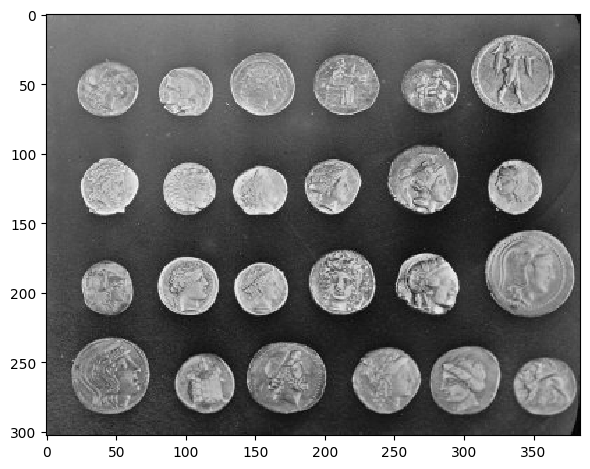

In [ ]:
import skimage as sk
from skimage import data, img_as_ubyte
import matplotlib.pyplot as plt

I = data.coins()
sk.io.imshow(I)
sk.io.show()

**Step 2**: Convert grayscale if necessary

Since the image is already in grayscale, no color-to-grayscale conversion was required. Each pixel already represents an intensity value between 0 and 1, which is suitable for clustering and thresholding methods.

**Step 3**: Preprocess

Gaussian noise is added to simulate real-world sensor noise and evaluate how robust different segmentation methods (Otsu, K-means, GMM) are under realistic conditions.

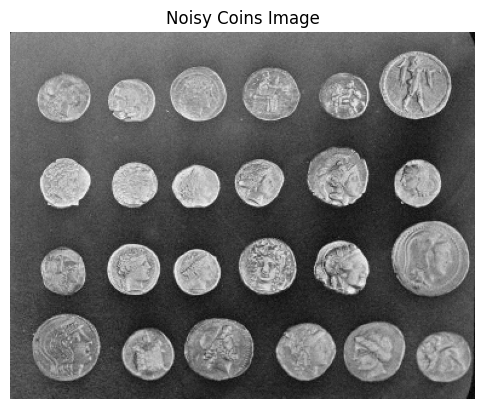

In [ ]:
import numpy as np
sigma = 5
In = I + sigma * np.random.normal(0, 1, I.shape)

plt.figure(figsize=(6, 6))
plt.imshow(In, cmap='gray')
plt.title("Noisy Coins Image")
plt.axis('off')
plt.show()

**Step 4**: Apply Otsu (multithreshold preferably)

Otsu multithreshold is applied to segment the image into 4 intensity-based regions.
Otsu’s method finds thresholds that minimize intra-class variance.

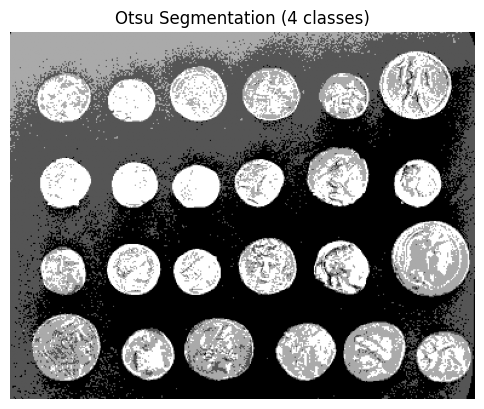

In [ ]:
from skimage.filters import threshold_multiotsu

thresholds = threshold_multiotsu(In, classes=4)
regions_otsu = np.digitize(In, bins=thresholds) # assigns each pixel to one of the 4 classes

plt.figure(figsize=(6, 6))
plt.imshow(regions_otsu, cmap='gray')
plt.title("Otsu Segmentation (4 classes)")
plt.axis('off')
plt.show()

**Step 5**: Apply K-means (same K as Otsu)

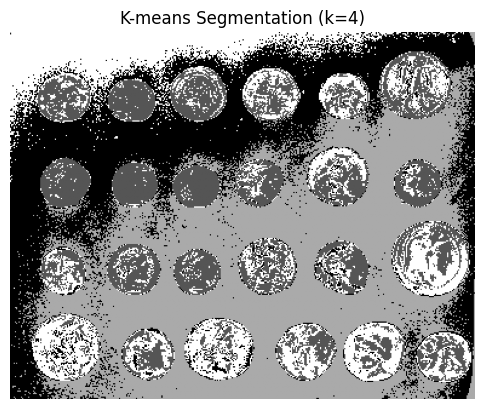

In [ ]:
from sklearn.cluster import KMeans

v_I = In.reshape(-1, 1)
kmeans = KMeans(n_clusters=4, random_state=0).fit(v_I)
I_kmeans = kmeans.predict(v_I).reshape(I.shape)

plt.figure(figsize=(6, 6))
plt.imshow(I_kmeans, cmap='gray')
plt.title("K-means Segmentation (k=4)")
plt.axis('off')
plt.show()

**Step 7**: Apply GMM, use BIC/AIC analysis to determine kG

Best number of GMM components according to BIC: 6
Best number of GMM components according to AIC: 6


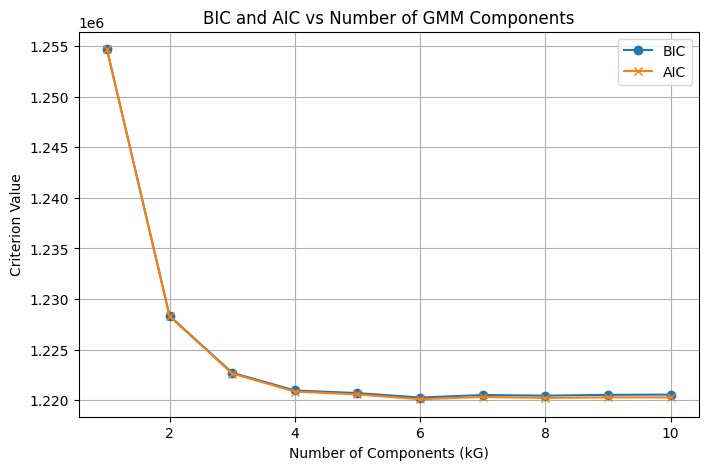

In [ ]:
from sklearn import mixture
import numpy as np
import matplotlib.pyplot as plt

NMAX = 10
bic = []
aic = []

# Fit GMM models with different numbers of components
for kG in range(1, NMAX + 1):
    gmm = mixture.GaussianMixture(n_components=kG, covariance_type='full').fit(v_I)
    bic.append(gmm.bic(v_I))
    aic.append(gmm.aic(v_I))

# Determine best number of components according to BIC and AIC
best_k_bic = np.argmin(bic) + 1
best_k_aic = np.argmin(aic) + 1

print(f"Best number of GMM components according to BIC: {best_k_bic}")
print(f"Best number of GMM components according to AIC: {best_k_aic}")

plt.figure(figsize=(8, 5))
plt.plot(range(1, NMAX + 1), bic, marker='o', label='BIC')
plt.plot(range(1, NMAX + 1), aic, marker='x', label='AIC')
plt.title("BIC and AIC vs Number of GMM Components")
plt.xlabel("Number of Components (kG)")
plt.ylabel("Criterion Value")
plt.legend()
plt.grid(True)
plt.show()

Both BIC and AIC selected 6 as the optimal number of GMM components because the image data is well represented by six distinct intensity clusters. BIC and AIC often agree when the underlying structure is clear and the amount of data is sufficient, as in this case with the coin image.

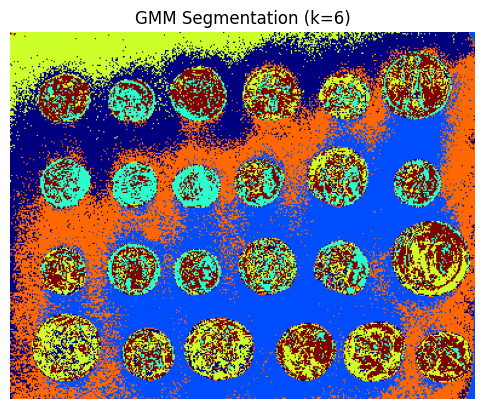

In [ ]:
best_k = best_k_bic
gmm_best = mixture.GaussianMixture(n_components=best_k, covariance_type='full').fit(v_I)
I_gmm = gmm_best.predict(v_I).reshape(I.shape)

plt.figure(figsize=(6, 6))
plt.imshow(I_gmm, cmap='jet')
plt.title(f"GMM Segmentation (k={best_k})")
plt.axis('off')
plt.show()

**Step 8**: Redo Otsu and k-means with k = kG

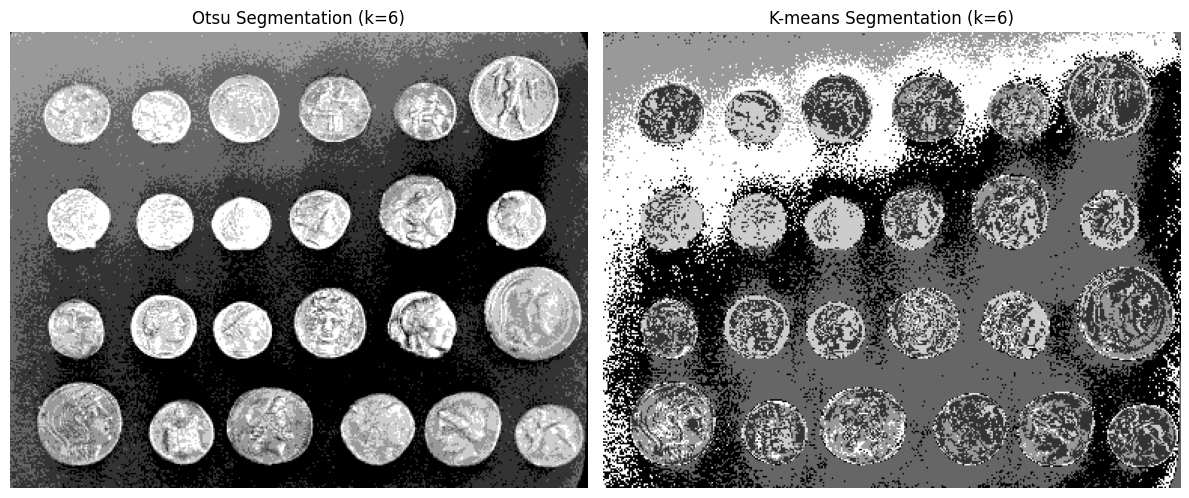

In [ ]:
thresholds_kG = threshold_multiotsu(In, classes=best_k)
regions_otsu_kG = np.digitize(In, bins=thresholds_kG)

kmeans_kG = KMeans(n_clusters=best_k, random_state=0).fit(v_I)
I_kmeans_kG = kmeans_kG.predict(v_I).reshape(I.shape)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(regions_otsu_kG, cmap='gray')
plt.title(f"Otsu Segmentation (k={best_k})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(I_kmeans_kG, cmap='gray')
plt.title(f"K-means Segmentation (k={best_k})")
plt.axis('off')

plt.tight_layout()
plt.show()

**Step 9**: Display and compare results, comment them briefly


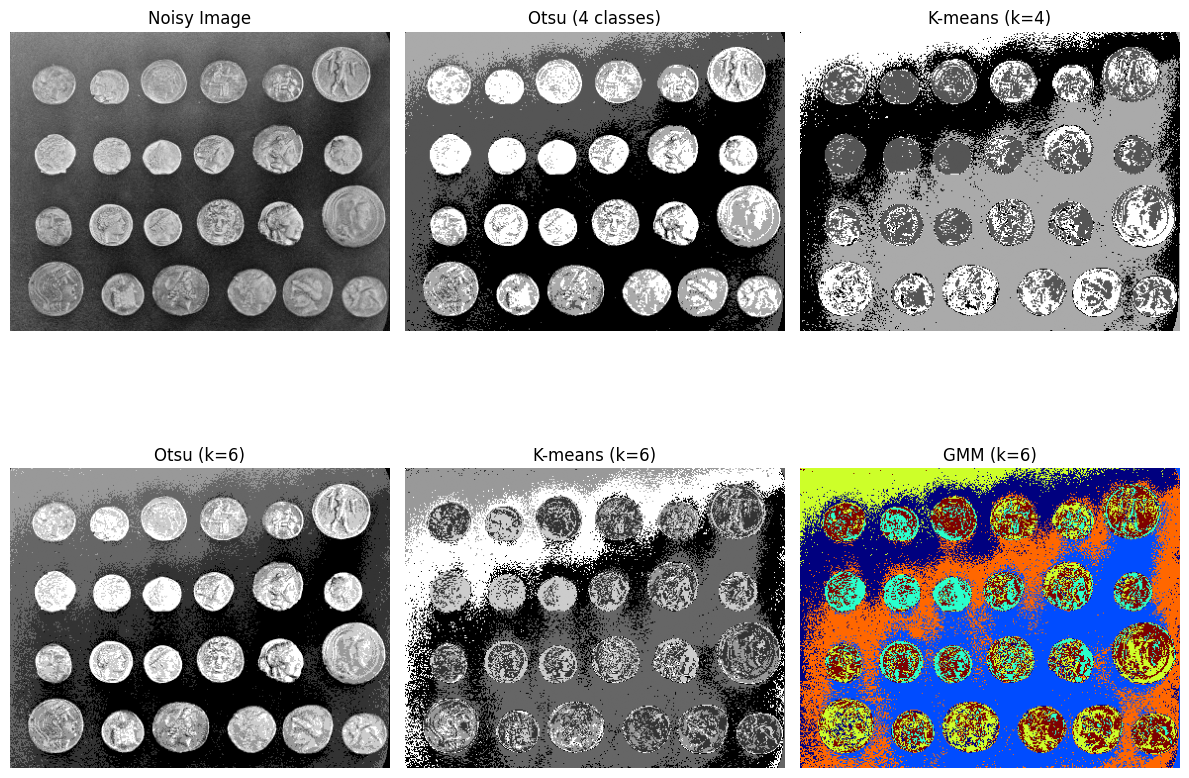

In [ ]:
plt.figure(figsize=(12, 10))

# Original noisy image
plt.subplot(2, 3, 1)
plt.imshow(In, cmap='gray')
plt.title("Noisy Image")
plt.axis('off')

# Otsu 4 classes
plt.subplot(2, 3, 2)
plt.imshow(regions_otsu, cmap='gray')
plt.title("Otsu (4 classes)")
plt.axis('off')

# K-means 4 clusters
plt.subplot(2, 3, 3)
plt.imshow(I_kmeans, cmap='gray')
plt.title("K-means (k=4)")
plt.axis('off')

# GMM segmentation
plt.subplot(2, 3, 6)
plt.imshow(I_gmm, cmap='jet')
plt.title(f"GMM (k={best_k})")
plt.axis('off')

# Otsu with optimal kG
plt.subplot(2, 3, 4)
plt.imshow(regions_otsu_kG, cmap='gray')
plt.title(f"Otsu (k={best_k})")
plt.axis('off')

# K-means with optimal kG
plt.subplot(2, 3, 5)
plt.imshow(I_kmeans_kG, cmap='gray')
plt.title(f"K-means (k={best_k})")
plt.axis('off')

plt.tight_layout()
plt.show()

- K-means: Handles gradual intensity variations better, producing smoother clusters and preserving coin textures.

- GMM: Most detailed; probabilistic approach captures subtle variations in coin surfaces and shadows, but sensitive to noise.

- k value effect: Increasing 𝑘 improves segmentation detail across both k-means and GMM.

**Team Members**:
- Apostolia Maria Sofianopoulou
- Paula Eva Wagner
- Sandra Catalina Parra Navarrete